# Install dependencies

In [1]:
!pip install --user --upgrade pip

In [2]:
!pip install torch==1.8.2 torchvision==0.9.2 torchaudio===0.8.2 --extra-index-url https://download.pytorch.org/whl/lts/1.8/cu111

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/lts/1.8/cu111


In [3]:
!pip install --user easyocr --quiet

In [4]:
!pip install -r yolov5/requirements.txt --quiet

# Clone yolov5 repository 

In [5]:
#!git clone https://github.com/ultralytics/yolov5

# Import dependencies

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import os
import easyocr

In [7]:
#Download easy ocr reader
reader = easyocr.Reader(['en'])

Progress: |██------------------------------------------------| 5.8% Complete

Progress: |█████████-----------------------------------------| 19.3% Complete

Progress: |████████████████----------------------------------| 33.0% Complete

Progress: |███████████████████████---------------------------| 47.6% Complete

Progress: |███████████████████████████████-------------------| 62.4% Complete

Progress: |██████████████████████████████████████------------| 77.2% Complete

Progress: |█████████████████████████████████████████████-----| 91.2% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |███████████████-----------------------------------| 30.9% Complete

Progress: |███████████████████████████████████████████████---| 94.5% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

# Train model

In [8]:
#Validate GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
#!python yolov5/train.py --batch 16 --epochs 500 --data yolov5/dataset.yml --weights yolov5s.pt

# Load model and predict

In [10]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path = 'yolov5/runs/train/exp/weights/last.pt', force_reload = True)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /home/ubuntu/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-9-24 Python-3.8.8 torch-1.8.2+cu111 CUDA:0 (NVIDIA A10G, 22732MiB)

Fusing layers... 
Model summary: 157 layers, 7055974 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


### View examples

image 1/1: 500x398 1 panini, 1 name
Speed: 18.2ms pre-process, 11.1ms inference, 1.4ms NMS per image at shape (1, 3, 640, 512)


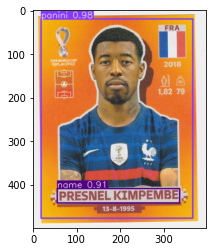

image 1/1: 500x390 1 panini, 1 name
Speed: 16.5ms pre-process, 8.0ms inference, 1.1ms NMS per image at shape (1, 3, 640, 512)


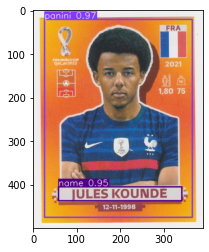

image 1/1: 500x405 1 panini, 1 name
Speed: 16.6ms pre-process, 11.0ms inference, 1.2ms NMS per image at shape (1, 3, 640, 544)


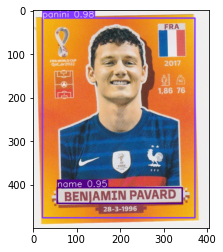

image 1/1: 500x389 1 panini, 1 name
Speed: 16.1ms pre-process, 8.3ms inference, 1.2ms NMS per image at shape (1, 3, 640, 512)


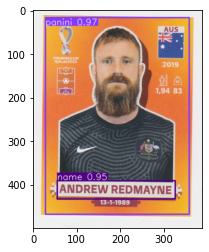

image 1/1: 500x396 1 panini, 1 name
Speed: 16.1ms pre-process, 7.9ms inference, 1.1ms NMS per image at shape (1, 3, 640, 512)


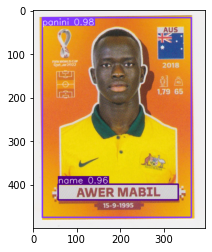

image 1/1: 500x401 1 panini, 1 name
Speed: 16.4ms pre-process, 8.3ms inference, 1.2ms NMS per image at shape (1, 3, 640, 544)


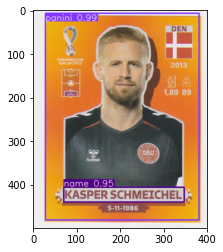

image 1/1: 500x392 1 panini, 1 name
Speed: 16.0ms pre-process, 8.2ms inference, 1.2ms NMS per image at shape (1, 3, 640, 512)


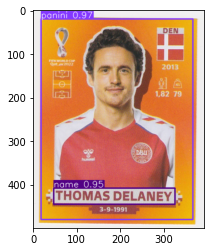

image 1/1: 500x391 1 panini, 1 name
Speed: 16.8ms pre-process, 7.9ms inference, 1.2ms NMS per image at shape (1, 3, 640, 512)


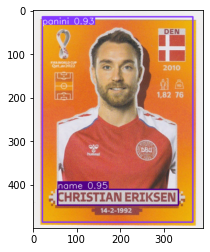

In [11]:
%matplotlib inline

for i in range(1,9):
    img = os.path.join('data','images','s-l500 ('+str(i)+').png')
    results = model(img)
    results.print()
    plt.imshow(np.squeeze(results.render()))
    plt.show()

# Label images using OCR

image 1/1: 225x191 1 panini, 1 name
Speed: 3.8ms pre-process, 8.3ms inference, 1.2ms NMS per image at shape (1, 3, 640, 544)


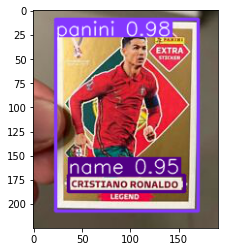

In [12]:
img = os.path.join('data','images','s-l225 (1).jpg')
results = model(img)
results.print()
plt.imshow(np.squeeze(results.render()))
plt.show()

In [13]:
#Get predictions
pred = results.pred[0].tolist()

In [14]:
#Filter scores 
all_scores = [pred[s][-2] for s in range(0,len(pred)) if len(pred)==2 and pred[s][-1]==16]

#Filter boxes
all_boxes = [pred[s][0:4] for s in range(0,len(pred)) if len(pred)==2 and pred[s][-1]==16]

#Filter classes
all_classes = [pred[s][-1] for s in range(0,len(pred)) if len(pred)==2 and pred[s][-1]==16]

In [15]:
detection_threshold = 0.7
scores = list(filter(lambda x: x>detection_threshold, all_scores))
boxes = all_boxes[:len(scores)][0]
classes = all_classes[:len(scores)]

### Crop image

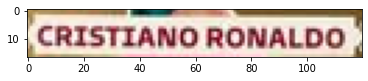

In [16]:
cropped_image = cv2.imread('data/images/s-l225 (1).jpg')[int(boxes[1]):int(boxes[3]), int(boxes[0]):int(boxes[2])]
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
ocr_result =  reader.readtext(cropped_image)

### Run optical character recognition (OCR)

In [17]:
ocr_result =  reader.readtext(cropped_image)
print(ocr_result[0][1])

CRISTIANO RONALDO


### Putting all together

Text(0.5, 1.0, 'CRISTIANO RONALDO')

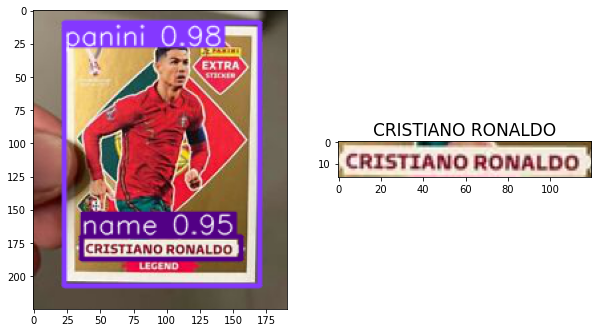

In [18]:
f, axarr = plt.subplots(1,2, figsize=(10, 10)) #Create subplts
axarr[0].imshow(np.squeeze(results.render())) #Load image with detections
axarr[1].imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)) #Load cropped image
axarr[1].set_title(ocr_result[0][1], fontsize=17) #Set title based on OCR

# Detect on live footage

In [20]:
!python yolov5/detect.py --conf-thres 0.7 --source data/videos/final_Video.MOV --weights yolov5/runs/train/exp/weights/last.pt 

detect: weights=['yolov5/runs/train/exp/weights/last.pt'], source=data/videos/final_Video.MOV, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.7, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
fatal: cannot change to '/mnt/Object': No such file or directory
YOLOv5 🚀 2022-9-19 Python-3.8.8 torch-1.8.2+cu111 CUDA:0 (NVIDIA A10G, 22732MiB)

Fusing layers... 
Model summary: 157 layers, 7055974 parameters, 0 gradients, 15.9 GFLOPs
video 1/1 (1/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 10.5ms
video 1/1 (2/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.9ms
video 1/1 (3/861) /mnt/Object Detection/data/videos/final_V

video 1/1 (74/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 9 paninis, 8 names, 7.3ms
video 1/1 (75/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 8 names, 7.3ms
video 1/1 (76/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 8 names, 7.5ms
video 1/1 (77/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 8 names, 7.4ms
video 1/1 (78/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 8 names, 7.4ms
video 1/1 (79/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 8 names, 7.4ms
video 1/1 (80/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 8 names, 7.5ms
video 1/1 (81/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 8 names, 7.4ms
video 1/1 (82/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 8 names, 7.5ms
video 1/1 (83/861) /mnt/Object Detection/data/videos/final_Video

video 1/1 (154/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 8 names, 7.5ms
video 1/1 (155/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 8 names, 7.4ms
video 1/1 (156/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 8 names, 7.4ms
video 1/1 (157/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 8 names, 7.5ms
video 1/1 (158/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 8 names, 7.4ms
video 1/1 (159/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 8 names, 7.4ms
video 1/1 (160/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 7 names, 7.5ms
video 1/1 (161/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 7 names, 7.5ms
video 1/1 (162/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 7 paninis, 7 names, 7.4ms
video 1/1 (163/861) /mnt/Object Detection/data/videos/f

video 1/1 (233/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 5 names, 7.5ms
video 1/1 (234/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 9 paninis, 7 names, 7.4ms
video 1/1 (235/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 7 names, 7.5ms
video 1/1 (236/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 6 names, 7.5ms
video 1/1 (237/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 9 paninis, 9 names, 7.5ms
video 1/1 (238/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 9 paninis, 8 names, 7.5ms
video 1/1 (239/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 9 paninis, 8 names, 7.4ms
video 1/1 (240/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 9 paninis, 6 names, 7.5ms
video 1/1 (241/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 9 paninis, 9 names, 7.6ms
video 1/1 (242/861) /mnt/Object Detection/data/videos/f

video 1/1 (313/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 7 paninis, 7 names, 7.8ms
video 1/1 (314/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 7 names, 7.9ms
video 1/1 (315/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 7 names, 7.8ms
video 1/1 (316/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 7 names, 7.8ms
video 1/1 (317/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 7 names, 7.8ms
video 1/1 (318/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 7 names, 7.8ms
video 1/1 (319/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 7 names, 7.6ms
video 1/1 (320/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 7 names, 8.0ms
video 1/1 (321/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 7 names, 7.6ms
video 1/1 (322/861) /mnt/Object Detection/data/videos/f

video 1/1 (393/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 9 paninis, 7 names, 7.6ms
video 1/1 (394/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 9 paninis, 6 names, 7.7ms
video 1/1 (395/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 9 paninis, 7 names, 7.7ms
video 1/1 (396/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 9 paninis, 7 names, 7.6ms
video 1/1 (397/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 6 names, 7.6ms
video 1/1 (398/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 6 names, 7.7ms
video 1/1 (399/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 8 names, 7.5ms
video 1/1 (400/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 4 names, 7.5ms
video 1/1 (401/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 8 paninis, 5 names, 7.5ms
video 1/1 (402/861) /mnt/Object Detection/data/videos/f

video 1/1 (474/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.5ms
video 1/1 (475/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.6ms
video 1/1 (476/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.6ms
video 1/1 (477/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.5ms
video 1/1 (478/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.5ms
video 1/1 (479/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.6ms
video 1/1 (480/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.5ms
video 1/1 (481/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.6ms
video 1/1 (482/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.5ms
video 1/1 (483/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no

video 1/1 (555/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.7ms
video 1/1 (556/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.6ms
video 1/1 (557/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.5ms
video 1/1 (558/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.5ms
video 1/1 (559/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.5ms
video 1/1 (560/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 1 panini, 7.6ms
video 1/1 (561/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.6ms
video 1/1 (562/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.6ms
video 1/1 (563/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 1 panini, 1 name, 7.6ms
video 1/1 (564/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 1 panini,

video 1/1 (637/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.5ms
video 1/1 (638/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.5ms
video 1/1 (639/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.5ms
video 1/1 (640/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.4ms
video 1/1 (641/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.4ms
video 1/1 (642/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.4ms
video 1/1 (643/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.4ms
video 1/1 (644/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.5ms
video 1/1 (645/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.5ms
video 1/1 (646/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 1 p

video 1/1 (719/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.8ms
video 1/1 (720/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.6ms
video 1/1 (721/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.5ms
video 1/1 (722/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.5ms
video 1/1 (723/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.5ms
video 1/1 (724/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.5ms
video 1/1 (725/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.5ms
video 1/1 (726/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.5ms
video 1/1 (727/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.5ms
video 1/1 (728/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no

video 1/1 (801/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.4ms
video 1/1 (802/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.7ms
video 1/1 (803/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.6ms
video 1/1 (804/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 1 name, 8.1ms
video 1/1 (805/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.6ms
video 1/1 (806/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.5ms
video 1/1 (807/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 1 name, 7.5ms
video 1/1 (808/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.7ms
video 1/1 (809/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.7ms
video 1/1 (810/861) /mnt/Object Detection/data/videos/final_Video.MOV: 640x384 (no detections), 7.6m